In [2]:
#Requires to have geopandas installed
#Installation https://geopandas.org/getting_started/install.html

import matplotlib.pyplot as plt 
import geopandas as gpd
import geoplot
import pandas as pd
import fiona #;help(fiona.open)
import requests
from pandas import json_normalize
import requests # convert json into dataframe
#For OSM 
import pyrosm
import numpy as np
from pyrosm import OSM, get_data

# Africa shape data

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world

In [4]:
saudi = world.query('name == "Saudi Arabia"')
yemen = world.query('name == "Yemen"')
iraq = world.query('name == "Iraq"')
oman = world.query('name == "Oman"')
uae = world.query('name == "United Arab Emirates"')
jordan = world.query('name == "Jordan"')
palestine = world.query('name == "Palestine"')
israel = world.query('name == "Israel"')
qatar = world.query('name == "Qatar"')
kuwait = world.query('name == "Kuwait"')

mena = saudi.append(yemen).append(iraq).append(oman).append(uae).append(jordan).append(palestine).append(israel).append(qatar).append(kuwait)

In [5]:
africa = world.query('continent == "Africa"').append(mena)
#africa.head()

In [8]:
#africa.plot()

# Power data

In [11]:
import os
import sys

In [50]:
pathg = os.path.realpath("data")+'/africa_all_generators.geojson'
paths = os.path.realpath("data")+'/africa_all_substations.geojson'
pathl = os.path.realpath("data")+'/africa_all_lines.geojson'

generators = gpd.read_file(pathg)
substations = gpd.read_file(paths)
lines = gpd.read_file(pathl)

# Map

<AxesSubplot:>

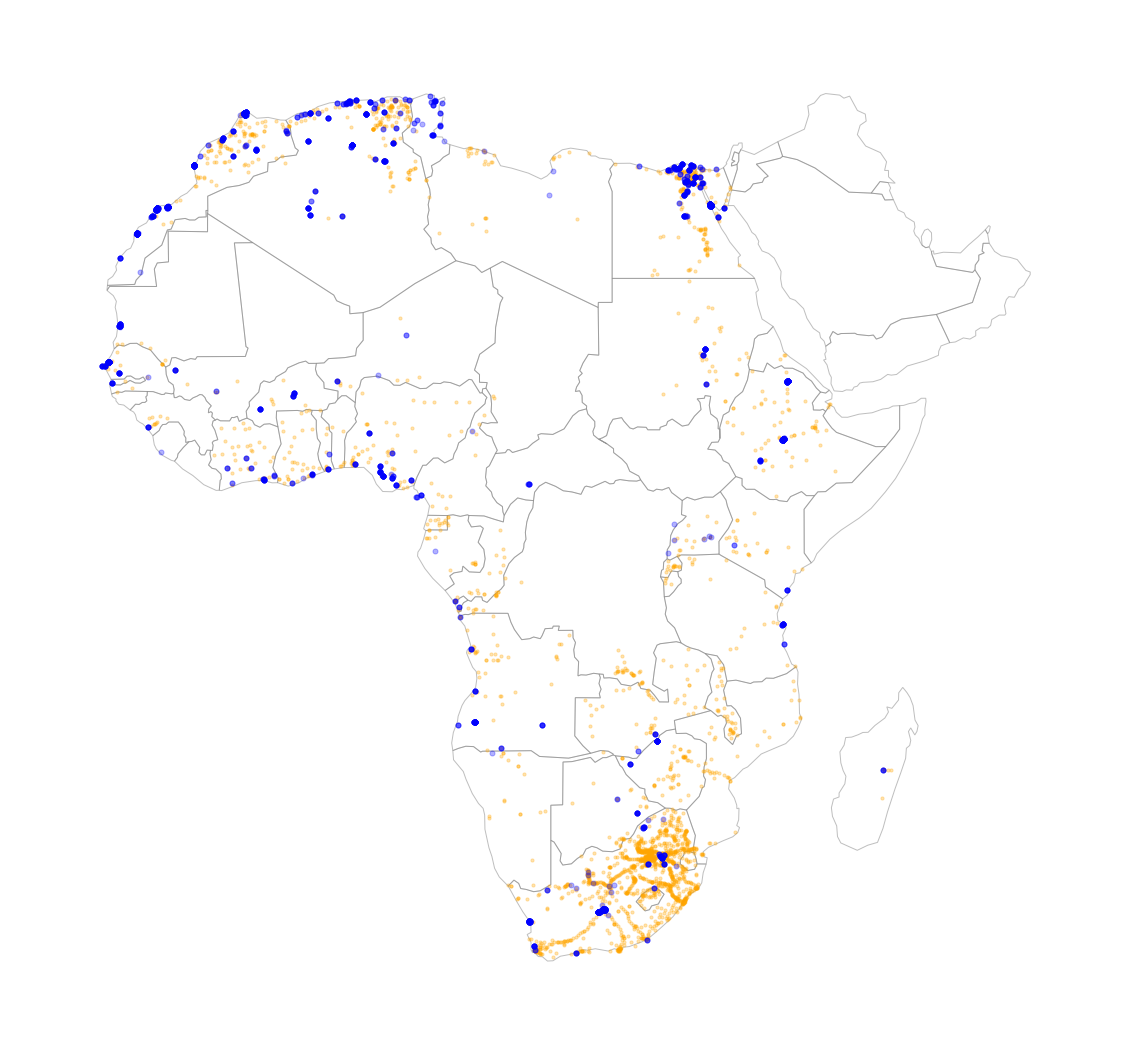

In [72]:
ax = geoplot.polyplot(africa ,edgecolor='grey', alpha = 0.5, figsize=(20, 20))

substations.plot(figsize=(20, 20),markersize=10, color='orange',alpha = 0.3, ax=ax)
generators.plot(figsize=(20, 20),markersize=25, color='blue',alpha = 0.3, ax=ax)
#network.plot(figsize=(20, 20),markersize=25, color='blue',alpha = 0.3, ax=ax)


#plt.savefig('africa_transmission_and substations_110.png')